# Загружаем необходимые библиотеки

In [83]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import time
from pathlib import Path
import csv
import openpyxl

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

#!pip install ipywidgets


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lapte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lapte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
#!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## Количество ядер процессора

### для каждой машины свои значения

In [3]:
import multiprocessing as mp
n_workers = mp.cpu_count()
print(f"{n_workers} workers are available")

4 workers are available


# Загрузим файл и посмотрим на него

## Мультипроцессорная обработка данных: Посчитаем количество строк в файле с помощью пандас

In [92]:
# Вариант с циклом
dataset_path =Path('parsed_data.csv')
chunksize = 100
df_chunks = pd.read_csv(
    dataset_path,
    encoding='utf-8',
    chunksize=chunksize)

start_time = time.time()
sizes = []
for chunk in df_chunks:
    sizes.append(len(chunk))
print(f'Количество строк {sum(sizes)}')
print(f'Время выполнения: {round(time.time() - start_time, 2)} секунд.')


Количество строк 11375
Время выполнения: 3.05 секунд.


## Выведем в консоли размер полученного объекта, названия его столбцов и продолжительность операции чтения файла.

In [93]:
%%time
df = pd.read_csv('parsed_data.csv', encoding='utf-8')

print(f"Shape:{df.shape}\n\nColumn Names:\n{df.columns}\n")

Shape:(11375, 2)

Column Names:
Index(['url', 'content'], dtype='object')

CPU times: total: 2.53 s
Wall time: 2.82 s


In [94]:
df.head(10)

,url,content
0,https://0-100km.ru,NaN
1,https://0-chan.ru,анонимная имиджборда Лого нультиреча вкл луп в...
2,https://0-12.ru,NaN
3,https://0--5.ru,Видионаблюдение Монтаж ремонт обслуживание Вид...
4,https://0-0-1.ru,Главная Корпоративный сайт по продаже компьюте...
5,https://0-base.ru,Без названия Без названия Без названия Поиск л...
6,https://0-nds.ru,Закладки Мед в Заволжск Закладки Мед в Заволжс...
7,https://0-ede.ru,О еде Рецепты блюд и секреты кулинарии Рецепты...
8,https://0--0-0.ru,Автомобильный портал автоновости отзывы автовл...
9,https://0-d.ru,Приветствуем Сайт только что создан Содержимое...


## Удалим строчки содержащие NaN

In [95]:
df = df.dropna()
# Убедимся, что строк содержащих NaN нет
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9919 entries, 1 to 11374
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      9919 non-null   object
 1   content  9919 non-null   object
dtypes: object(2)
memory usage: 232.5+ KB


# Функция возвращяющая dataframe с некорректными символами содержащимися в столбце

In [96]:
def get_illegal_characters(df, column_name, legitimate_characters, encoding='utf8', DEBUG=False):
  # получим все не легитимные символы из датафрейма
  result = df['content'].str.extractall(legitimate_characters)

  # Решим проблему с повторениями.
  result = result[0].unique()

  result = pd.DataFrame(result)

  # Добавим столбец с hex кодировкой символов.
  result['hex_code'] = result[0].str.encode(encoding)

  # Дадим адекватные имена столбцам.
  result.rename(columns={0: 'character'}, inplace=True)

  if (DEBUG):
    print("Найдено", result.shape[0], "уникальных символов не подходящих под заданный шаблон.")
    print("Найдены следующие символы:\n", result)

  return result
# Шаблон "легитимных символов". Использование этих символов допустимо в русском языке.
# Естественно символ пробела мы тоже оставим, иначе наши слова "склеятся".
legitimate_characters = "([^а-яёА-ЯЁ ])"

# Имя столбца, который необходимо проверить
column_name = 'content'

bad_symbols =  get_illegal_characters(df, column_name, legitimate_characters)

bad_symbols


,character,hex_code


## Создаем функцию, которая очищает текст от ненужных символов

In [97]:
import re

def clean_text(text):
    template = '|'.join(map(re.escape, bad_symbols['character']))
    # Удаление ненужных символов из строки.
    text = re.sub(template, '', text, flags=re.UNICODE)
    return text




## Протестируем различные методы очистки слов в тексте

Последовательный метод очистки текста

In [10]:
#!pip install --upgrade jupyter
#!pip install --upgrade ipywidgets

In [98]:
from tqdm import tqdm
from time import sleep

tqdm.pandas()
%time df['content'] = df['content'].progress_apply(clean_text)
sleep(0.01)



100%|██████████| 9919/9919 [00:25<00:00, 393.67it/s]

CPU times: total: 24.6 s
Wall time: 25.2 s


Очищаем текст с помощью модуля multiprocessing: не работает в Anaconda

In [ ]:
%time
import multiprocessing as mp
from tqdm.notebook import tqdm

n_workers = 4  # количество распараллеленых процессов(воркеров)

# Создание многопроцессорного пула
p = mp.Pool(n_workers)

# Примените функцию cleana_text к каждому элементу столбца 'content'
# путем передачи отдельных строк
text = list(tqdm(p.imap(clean_text, df['content']), total=len(df)))
p.close()
p.join()


CPU times: total: 0 ns
Wall time: 0 ns


  0%|          | 0/9919 [00:00<?, ?it/s]

# Анализ текста

## Количество уникальных слов


In [99]:
from collections import Counter

text = df['content'].tolist()

# Функция возвращающая общее количество уникальных слов и общее кол-во их вместе взятая
def word_stats(word_counts):
    num_unique = len(word_counts)
    counts = list(word_counts.values())  
    return num_unique, counts

# Вычисление частот слов с помощью счетчика
word_counts = Counter(text)

# вызов функции
num_unique, counts = word_stats(word_counts)
print("Число уникальных слов:", num_unique)
print("сумма частот уникальных слов:", sum(counts))


Число уникальных слов: 8991
сумма частот уникальных слов: 9919


## Популярные слова

In [100]:
#сохраним данные столбца 'content' с типом str, чтобы можно было работать с nltk
content = ' '.join(df['content'])  # Объединить с пробелом в качестве разделителя
text=content.lower() # все с маленькой буквы

print(type(text))
print(text[:300])

<class 'str'>
анонимная имиджборда лого нультиреча вкл луп выкл луп лого нультиреча вкл луп нас не работает главная все доски тематика аниме радиоэлектроника мех политач тульпафорсинг и саморазвитие зеркало зеркало не работает главная метадоска с лучшим обсуждение медиаконтента такого как книги комиксы фильмы ани


In [13]:
%%time

start_time = time.time()
# токенизируем текст
words = word_tokenize(text)

# Создаем список со стоп словами для русского языка
stop_words = stopwords.words('russian')
stop_words.extend(['это', 'что','всё','м', 'г', 'р'])

# Удаляем стоп слова
nouns = [word for word in words if word not in stop_words]

# Вычисление частот слов
fdist = FreqDist(nouns)

# Получите 10 популярных слов
most_common_words = fdist.most_common(10)

print(most_common_words)


[('отдых', 97377), ('руб', 34617), ('сайт', 24983), ('работа', 23591), ('купить', 23536), ('данных', 19696), ('подробнее', 19681), ('поиск', 17285), ('ремонт', 17136), ('доставка', 15209)]
CPU times: total: 2min 6s
Wall time: 2min 8s


In [18]:
#преобразуем кортеж в таблицу для лучшей визуализации
df2 = pd.DataFrame(most_common_words, columns=['word', 'count'])
df2

,word,count
0,отдых,97377
1,руб,34617
2,сайт,24983
3,работа,23591
4,купить,23536
5,данных,19696
6,подробнее,19681
7,поиск,17285
8,ремонт,17136
9,доставка,15209


Нарисуем гистограмму распределения часто встречющихся слов

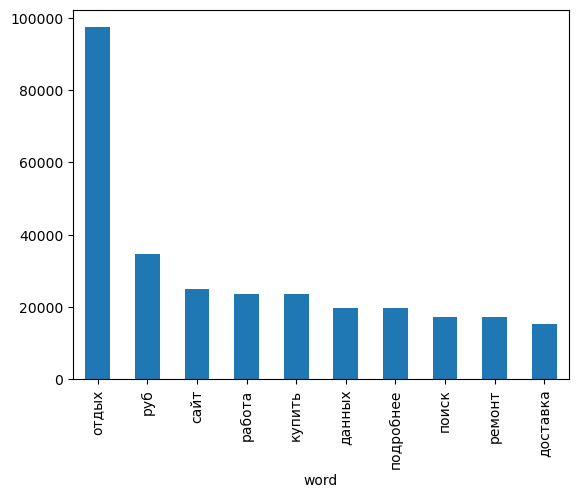

In [19]:
axes = df2.plot.bar(x='word', y='count', legend=False)

## Визуализация популярности слов в виде облака

Скачиваем необходимые библиотеки

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

Выведим слова в виде красивой картинки, используя библиотеку WordCloud

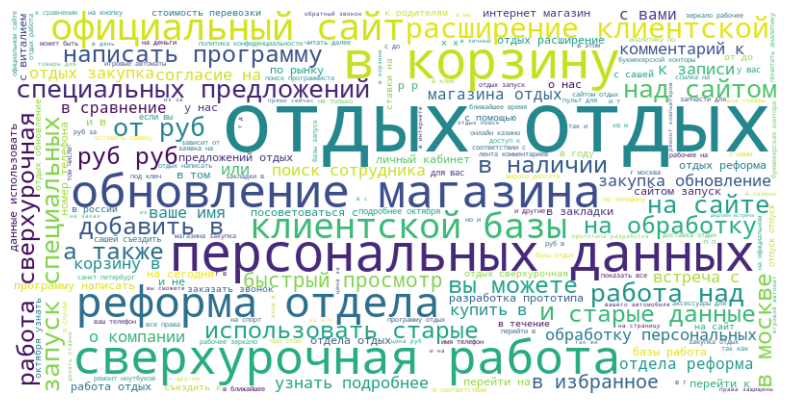

In [17]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Частота вхождения заданных слов в столбце

In [79]:
print(f"количество сайтов, содержащих слово Контакты: {df.content.str.contains('контакты', na=False).sum()}\n")
print(f"количество сайтов, содержащих слово ИНН: {df.content.str.contains('ИНН', na=False).sum()}\n")
print(f"количество сайтов, содержащих слово телефон: {df.content.str.contains('Телефон', na=False).sum()}\n")
print(f"количество сайтов, содержащих слово адрес: {df.content.str.contains('адрес', na=False).sum()}\n")
print(f"количество сайтов, содержащих слово МФТИ: {df.content.str.contains('МФТИ', na=False).sum()}\n")
df1 = df[df['content'].str.contains("МФТИ")] 
print(df1) 

количество сайтов, содержащих слово Контакты: 889

количество сайтов, содержащих слово ИНН: 810

количество сайтов, содержащих слово телефон: 2773

количество сайтов, содержащих слово адрес: 2571

количество сайтов, содержащих слово МФТИ: 3

                       url                                            content  \
1255  https://1-variant.ru  Главная Вариант это дефолтный вариант Вариант ...   
5655   https://1cov-edu.ru  Методы решения физико математических задач выс...   
9951   https://231-tech.ru  Главная Главная страница сайта студенческих се...   

      query_count  
1255            1  
5655            1  
9951            1  


## Частота вхождения заданных словосочетаний

In [78]:
# Ищем словосочетание в столбце 'content'
result = df[df['content'].str.contains('адрес челябинск', case=False, na=False)]
print(result)

#Запись результата в excel, если небходимо
#new_df.to_excel('Студент мгу.xlsx', index=False)

                            url  \
150           https://007spa.ru   
3671           https://127ds.ru   
4115       https://147school.ru   
5518      https://1ccrm-tech.ru   
7386         https://1signal.ru   
9630         https://22-volt.ru   
9717         https://2221001.ru   
10734  https://24facecontrol.ru   

                                                 content  query_count  
150    Спа салон для мужчин Эротического массажа в Че...            1  
3671   МБДОУ Детский сад г Челябинска Муниципальное б...            1  
4115   Школа Челябинска официальный сайт МАОУ СОШ Чел...            1  
5518   С решения для взаимоотношения с клиентами Глав...            1  
7386   Автошкола в Троицке Сигнал Автошкола Сигнал Ав...            1  
9630   Газклимат газовые котлы и газовое оборудование...            1  
9717   АвтоАдвокат Услуги автоадвоката в Челябинске п...            1  
10734  ЛайтШоп Главная Интернет магазин заказать купи...            1  
